In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from random import seed
from random import randrange
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os, sys, getopt, pdb
from numpy import *
from numpy.linalg import *
from numpy.random import *
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.manifold import Isomap
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.sparse import linalg, eye
#from pyamg import smoothed_aggregation_solver
#from scikits.learn import neighbors
#from pyamg.aggregation import adaptive_sa_solver
from sklearn.neighbors import NearestNeighbors
clusters = np.loadtxt('clusters.txt') 
swissroll = np.loadtxt('swissroll.txt')
halfmoons = np.loadtxt('halfmoons.txt')


In [2]:
def plot_MDS(data, n, labelled = True):
    D = pairwise_distances(data)
    model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    proj = model.fit_transform(D)
    if labelled:
        labels = data[:,-1]
        for i in range(1,n+1):
            plt.plot(proj[labels==i,0], proj[labels==i, 1],'o')
        plt.axis('equal');
    else:
        plt.plot(proj[:,0], proj[:, 1],'o')

    plt.title('MDS')
    plt.show()
def plot_ISOMAP(data, n,  neighbors, labelled = True):
    model = Isomap(n_neighbors=neighbors,n_components=2)
    proj = model.fit_transform(data)
    if labelled:
        labels = data[:,-1]
        for i in range(1,n+1):
            plt.plot(proj[labels==i,0], proj[labels==i, 1],'o')
        plt.axis('equal');
    else:
        plt.plot(proj[:,0], proj[:, 1],'o')

    plt.title('IsoMap')
    plt.show()
def plot_LLE(data, n, neighbors,labelled = True):
    model = LLE(n_neighbors=neighbors, n_components=2, method='modified', eigen_solver='dense')
    proj = model.fit_transform(data)
    if labelled:
        labels = data[:,-1]
        for i in range(1,n+1):
            plt.plot(proj[labels==i,0], proj[labels==i, 1],'o')
        plt.axis('equal');
    else:
        plt.plot(proj[:,0], proj[:, 1],'o')

    plt.title('LLE')
    plt.show()

In [3]:
def classical_MDS(data, n = 0):
    labelled = True
    if n == 0:
        labelled = False
    D = pairwise_distances(data)
    # Number of points                                                                        
    n = len(D)
 
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
 
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
 
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
 
    # Sort by eigenvalue in descending order                                                  
    idx   = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]
 
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals > 0)
    L  = np.diag(np.sqrt(evals[w]))
    V  = evecs[:,w]
    Y  = V.dot(L)
    proj = Y[:,:n + 1] 
    if labelled:
        labels = data[:,-1]
        for i in range(1,n+1):
            plt.plot(proj[labels==i,0], proj[labels==i, 1],'o')
        plt.axis('equal');
    else:
        plt.plot(proj[:,0], proj[:, 1],'o')

    plt.title('MDS')
    plt.show()


In [4]:
def LLE_algo(k,input_data, n,labelled = True):
    data = []
    if labelled == True:
        data = input_data[:,:-1]
    else:
        data = input_data
    neigh = NearestNeighbors(k)
    neigh.fit(data)
    _,id=neigh.kneighbors(data)
    N = len(data)
    M = len(data[0])
    id=id[:,1:]
    W = np.matrix(np.ones((N,N)) * 0)
    for i in range(N):
        v = np.matrix(np.ones((k-1,M)))
        for j in range(k-1):
            v[j] = data[id[i][j]]
        V=v.T       
        xi = []
        for j in range(k-1):
            xi.append(data[i])
        xi=np.array(xi)
        xi=xi.T
        G=(xi-V).T@(xi-V)
        wi = np.linalg.inv(G).dot(np.ones(k-1))
        wi=wi/np.sum(wi)
        wi=wi.T
        for j in range(len(id[0])):
            W[i,id[i,j]] = wi[j]
    M=(np.eye(N) - W.T)@((np.eye(N)-W.T).T)
   
    eigen_vals, eigen_vecs = np.linalg.eigh(M)
    eigen_vals = abs(eigen_vals)
    idx = np.argsort(eigen_vals)
    eigen_vals = eigen_vals[idx]
    eigen_vecs = eigen_vecs[:,idx]
    eigen_vecs = eigen_vecs[:,1:]
    y = eigen_vecs[:,:2]
    if labelled:
        labels = input_data[:,-1]
        for i in range(1,n+1):
            plt.plot(y[labels==i,0], y[labels==i, 1],'o')
        plt.axis('equal');
    else:
        plt.plot(y[:,0], y[:, 1],'o')

    plt.title('LLE')
    plt.show()

def locally_linear_embedding(X, n_neighbors = 12, out_dim = 2, tol=1e-6, max_iter=200):
    W = NearestNeighbors.kneighbors_graph(
        X, n_neighbors=n_neighbors, mode='barycenter')
    
    # M = (I-W)' (I-W)
    A = eye(*W.shape, format=W.format) - W
    A = (A.T).dot(A).tocsr()

    # initial approximation to the eigenvectors
    X = np.random.rand(W.shape[0], out_dim)
    ml = smoothed_aggregation_solver(A, symmetry='symmetric')
    prec = ml.aspreconditioner()

    # compute eigenvalues and eigenvectors with LOBPCG
    eigen_values, eigen_vectors = linalg.lobpcg(
        A, X, M=prec, largest=False, tol=tol, maxiter=max_iter)

    index = np.argsort(eigen_values)
    X_r, cost = eigen_vectors[:, index], np.sum(eigen_values)

#X_r, cost = locally_linear_embedding(data, n_neighbors, out_dim)

    sp = pl.subplot(212)
    sp.scatter(X_r[:,0], X_r[:,1], c=colors)
    sp.set_title("LLE embedding")
    pl.show()

In [5]:
# ISOMAP Functions 

def distance_matrix(X, n_neighbors=3):
    """
    Compute the square distance matrix using Euclidean distance
    :param X: Input data, a numpy array of shape (img_height, img_width)
    :param n_neighbors: Number of nearest neighbors to consider, int
    :return: numpy array of shape (img_height, img_height), numpy array of shape (img_height, n_neighbors)
    """
    def dist(a, b):
        return np.sqrt(sum((a - b)**2))

    # Compute full distance matrix
    distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

    # Keep only the 6 nearest neighbors, others set to 0 (= unreachable)
    neighbors = np.zeros_like(distances)
    sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
    for k,i in enumerate(sort_distances):
        neighbors[k,i] = distances[k,i]
    return neighbors, sort_distances

def isomap(input_data, n=2, n_neighbors=6):
    """
    Dimensionality reduction with isomap algorithm
    :param data: input image matrix of shape (n,m) if dist=False, square distance matrix of size (n,n) if dist=True
    :param n_components: number of components for projection
    :param n_neighbors: number of neighbors for distance matrix computation
    :return: Projected output of shape (n_components, n)
    """
    # Compute distance matrix
    #print(input_data.shape)
    data = input_data[:, :-1]
    #print(data.shape)
    data, _ = distance_matrix(data, n_neighbors)

    # Compute shortest paths from distance matrix
    from sklearn.utils.graph import graph_shortest_path
    graph = graph_shortest_path(data, directed=False)
    graph = -0.5 * (graph ** 2)
    print(graph)
    # Return the MDS projection on the shortest paths graph
    labelled = True
    if n == 0:
        labelled = False
    D = graph
    
    #D = pairwise_distances(data)
    # Number of points                                                                        
    n = len(D)
 
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
 
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
 
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
 
    # Sort by eigenvalue in descending order                                                  
    idx   = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]
 
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals > 0)
    L  = np.diag(np.sqrt(evals[w]))
    V  = evecs[:,w]
    Y  = V.dot(L)
    proj = Y[:,:n + 1] 
    if labelled:
        labels = input_data[:,-1]
        for i in range(1,n+1):
            plt.plot(proj[labels==i,0], proj[labels==i, 1],'o')
        plt.axis('equal');
    else:
        plt.plot(proj[:,0], proj[:, 1],'o')

    plt.title('IsoMap')
    plt.show()

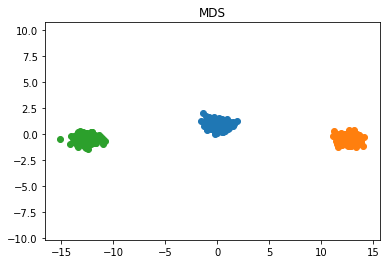

In [6]:
classical_MDS(clusters, 3)

(600, 11)
(600, 10)
[[  0.         -11.76410415 -12.33695596 ...   0.           0.
    0.        ]
 [-11.76410415   0.          -0.58045024 ...   0.           0.
    0.        ]
 [-12.33695596  -0.58045024   0.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.          -6.64600598
  -10.98531802]
 [  0.           0.           0.         ...  -6.64600598   0.
  -11.15867489]
 [  0.           0.           0.         ... -10.98531802 -11.15867489
    0.        ]]


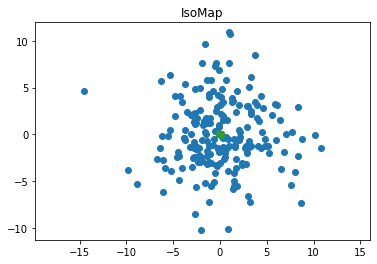

In [134]:
isomap(clusters, 3,10)

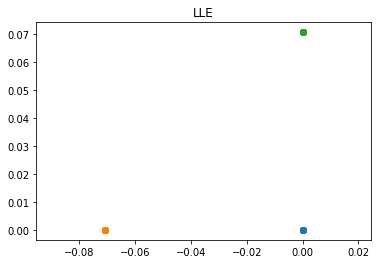

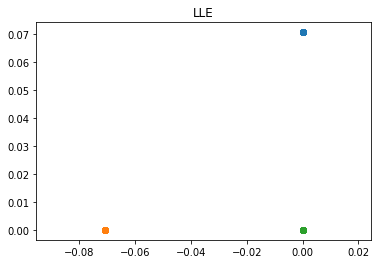

In [184]:
plot_LLE(clusters, 3, 10)
LLE_algo(10,clusters, 3,True)

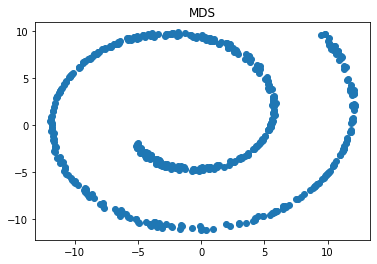

In [7]:
classical_MDS(swissroll, 0)

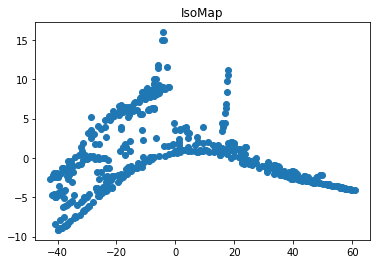

In [59]:
plot_ISOMAP(swissroll, 1,5, False)

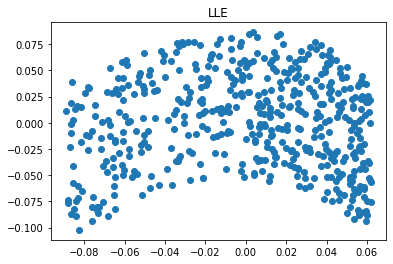

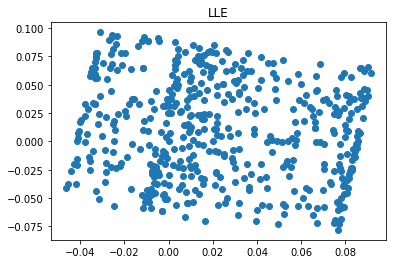

In [170]:
plot_LLE(swissroll, 1, 10, False)
LLE_algo(14,swissroll, False)

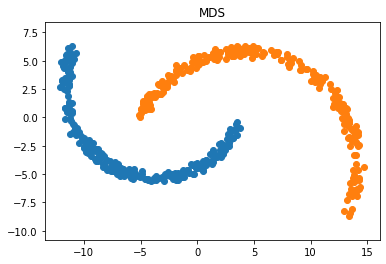

In [99]:
classical_MDS(halfmoons, 2)

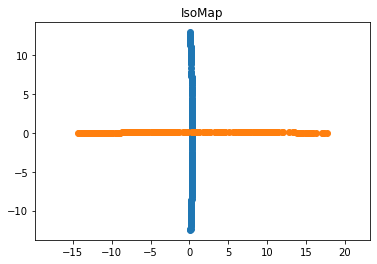

In [41]:
plot_ISOMAP(halfmoons, 2, 10)

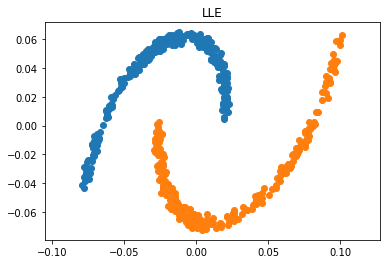

In [77]:
plot_LLE(halfmoons, 2, 58)